# Parametrizing

In [1]:
DATASET_CONFIG_PATH = 'config/dataset/kc1.json'
PROFILE_REPORTING = False

In [2]:
import json


with open(DATASET_CONFIG_PATH) as f:
    dataset_config = json.load(f)

# Profiling

In [3]:
import pandas as pd
from pandas_profiling import ProfileReport

In [4]:
df = pd.read_csv(dataset_config['dataset_path'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2109 non-null   int64  
 1   loc                2109 non-null   float64
 2   v(g)               2109 non-null   float64
 3   ev(g)              2109 non-null   float64
 4   iv(g)              2109 non-null   float64
 5   n                  2109 non-null   float64
 6   v                  2109 non-null   float64
 7   l                  2109 non-null   float64
 8   d                  2109 non-null   float64
 9   i                  2109 non-null   float64
 10  e                  2109 non-null   float64
 11  b                  2109 non-null   float64
 12  t                  2109 non-null   float64
 13  lOCode             2109 non-null   int64  
 14  lOComment          2109 non-null   int64  
 15  lOBlank            2109 non-null   int64  
 16  locCodeAndComment  2109 

In [6]:
df.head()

,id,loc,v(g),ev(g),iv(g),n,v,l,d,i,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,...,2,2,2,2,1.2,1.2,1.2,1.2,1.4,False
1,2,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,...,1,1,1,1,1.0,1.0,1.0,1.0,1.0,True
2,3,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,...,65,10,6,0,18.0,25.0,107.0,64.0,21.0,True
3,4,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,...,37,2,5,0,16.0,28.0,89.0,52.0,15.0,True
4,5,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,...,21,0,2,0,11.0,10.0,41.0,17.0,5.0,True


In [7]:
del df['id']

In [8]:
if PROFILE_REPORTING:
    ProfileReport(df).to_widgets()

# Preprocess

In [9]:
working_df = df.copy()

In [10]:
working_df['defects'] = working_df['defects'].replace([False, True], [0, 1])

In [12]:
working_df = working_df.drop_duplicates()
working_df = working_df.reset_index(drop=True)

In [28]:
working_df['defects'].value_counts()

0    825
1    313
Name: defects, dtype: int64

# Split

In [13]:
random_state = dataset_config['random_state']

In [14]:
inlier, outlier = working_df[working_df['defects'] == 0], working_df[working_df['defects'] == 1]

In [15]:
X_inlier = inlier.copy().reset_index(drop=True)
y_inlier = X_inlier.pop('defects').reset_index(drop=True)
X_outlier = outlier.copy().reset_index(drop=True)
y_outlier = X_outlier.pop('defects').reset_index(drop=True)

# Naive Bayes

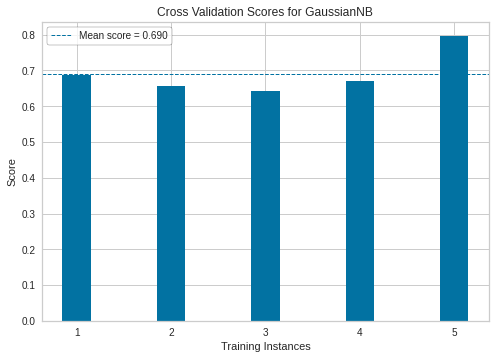

<AxesSubplot:title={'center':'Cross Validation Scores for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB

from yellowbrick.model_selection import CVScores


cv = StratifiedKFold(5)
visualizer = CVScores(GaussianNB(), cv=cv, scoring='f1_weighted', random_state=random_state)

X = pd.concat([X_inlier, X_outlier], ignore_index=True)
y = pd.concat([y_inlier, y_outlier], ignore_index=True)

visualizer.fit(X, y)
visualizer.show()

# 1-NN

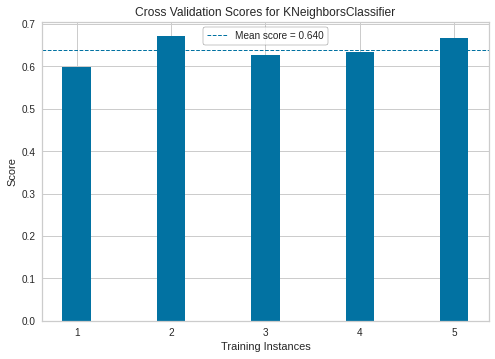

<AxesSubplot:title={'center':'Cross Validation Scores for KNeighborsClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [17]:
from sklearn.neighbors import KNeighborsClassifier


cv = StratifiedKFold(5)
visualizer = CVScores(KNeighborsClassifier(n_neighbors=1), cv=cv, scoring='f1_weighted', random_state=random_state)

X = pd.concat([X_inlier, X_outlier], ignore_index=True)
y = pd.concat([y_inlier, y_outlier], ignore_index=True)

visualizer.fit(X, y)
visualizer.show()

# Kmeans metaclasses + Naive Bayes

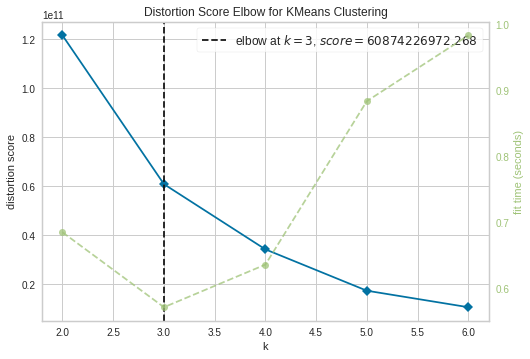

In [18]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer


model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), random_state=random_state)

visualizer.fit(X_inlier)
visualizer.show()
inlier_best_k = visualizer.elbow_value_

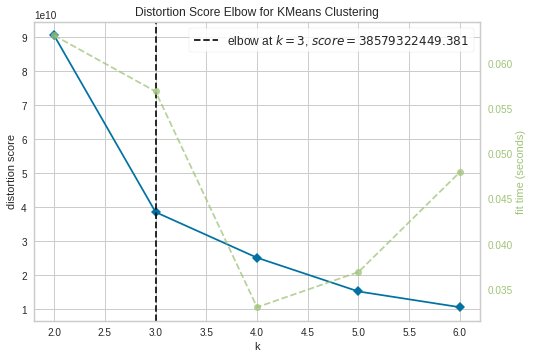

In [19]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,7), random_state=random_state)

visualizer.fit(X_outlier)
visualizer.show()
outlier_best_k = visualizer.elbow_value_

## Encoding metaclasses

In [20]:
y_inlier_clustered = pd.Series(KMeans(inlier_best_k, random_state=random_state).fit_predict(X_inlier))
y_outlier_clustered = pd.Series(KMeans(outlier_best_k, random_state=random_state).fit_predict(X_outlier))
y_outlier_clustered = y_outlier_clustered + inlier_best_k

In [21]:
X = pd.concat([X_inlier, X_outlier], ignore_index=True)
y = pd.concat([y_inlier_clustered, y_outlier_clustered], ignore_index=True)

/home/gcc/work/.virtualenvs/tmp-d8e6ef899cc5740/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


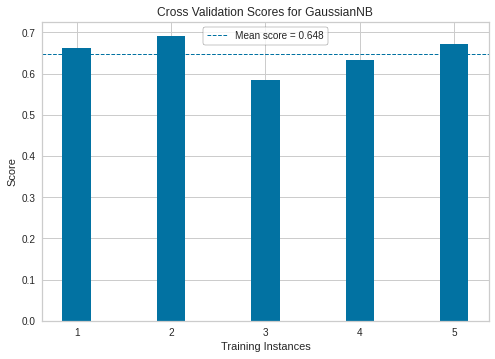

<AxesSubplot:title={'center':'Cross Validation Scores for GaussianNB'}, xlabel='Training Instances', ylabel='Score'>

In [22]:
cv = StratifiedKFold(5)
visualizer = CVScores(GaussianNB(), cv=cv, scoring='f1_weighted', random_state=random_state)

visualizer.fit(X, y)
visualizer.show()